***
# Cumulative Radiation events (CREs) analysis on a local scale
***
This notebook provides the analysis of Cumulative Radiation Events (CREs).

The data used in this notebook are from CMIP6 climate models. 
We are looking only at the grid box containing Zürich, Switzerland.

Copyright (c) 2023, ETH Zurich, Guillaume Senger

In [1]:
import my_functions
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from scipy import stats
import matplotlib.colors as mcolors

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

matplotlib.rcParams.update({'font.size': 24})

---
## Load data and compute moving averages

In [2]:
location       = 'Zurich' # Choose location of interest

output = pickle.load(open(f'Data/rsds/{location}.pickle', 'rb')) # Load data created using the script Get_Data_Local.py

model_names = {
    'CanESM5':         {'color': 'tab:orange'},
    'CESM2':           {'color': 'g'},
    'CMCC-CM2-SR5':    {'color': 'c'},
    'CMCC-ESM2':       {'color': 'm'},
    'GFDL-CM4':        {'color': 'y'},
    'GFDL-ESM4':       {'color': 'b'},
    'NorESM2-LM':      {'color': 'tab:purple'},
    'NorESM2-MM':      {'color': 'tab:brown'},
    'TaiESM1':         {'color': 'tab:pink'}  ,
    # 'INM-CM4-8':       {'color': 'tab:gray'}  ,
    # 'INM-CM5-0':       {'color': 'tab:olive'} ,
    # 'IPSL-CM5A2-INCA': {'color': 'tab:cyan'}  ,
    # 'KIOST-ESM':       {'color': 'tab:olive'}
}

Ls = np.arange(4,22) # CRE lengths of interest

time_series_dict = {}

for model_name in output:

    rsds = output[model_name]
    
    time_series_dict[model_name] = {
        'rsds': rsds,
        'n_years': len(rsds) // 365,
        'moving_avg': {}  # Create a sub-dictionary for moving averages
    }

    # Compute the moving averages for all lengths 
    for L in Ls:
        
        time_series_dict[model_name]['moving_avg'][L] = pd.Series(rsds).rolling(window=L, center=True).mean()

## Statistics computation

We fit the CREs with the GEV distribution and compute all the statistics.

- **GEV fit** : returns $\xi$ (shape parameter), $\mu$ (location parameter) and $\sigma$ (scale parameter)

    We have to be careful with the shape parameter sign convention. SciPy uses a different convention compare to how the GEV distribution is commonly used:
    
    - From the SciPy manual (https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.genextreme.html) one takes:
           $$ \mathrm{PDF}(z;c) = \exp\left[-(1-cz)^{1/c}\right] \times (1-cz)^{1/c - 1} $$    
    
    
    - From wikipedia (https://en.wikipedia.org/wiki/Generalized_extreme_value_distribution) one takes instead:
            $$ \mathrm{PDF}(z;\xi) = \exp\left[-(1+\xi z)^{-1/\xi}\right] \times (1+\xi z)^{-1/\xi - 1}$$

    where $z = \frac{x-\mu}{\sigma}$.
    
    $\rightarrow$ Consequently, we have $\xi = -c$.

       
- **Kolmogorov-Smirnov test** : Test the null hypothesis  $H_0$ : The empirical data follows a GEV distribution

    - KS Statistic (ks_statistic): Represents the magnitude of difference between the observed data and the expected distribution. A larger KS statistic indicates a greater difference between the observed data and the expected distribution.

    - P-value (p_value): The p-value represents the probability of obtaining a KS statistic as extreme as, or more extreme than, the observed value under the assumption that the null hypothesis is true:
    
        - If the p-value is small (below a predefined significance level, e.g., 0.05), it suggests that the observed data significantly deviates from the expected distribution, providing evidence to reject the null hypothesis in favor of an alternative hypothesis.

        - If the p-value is large, it indicates that the observed data is consistent with the expected distribution, and there is no significant evidence to reject the null hypothesis.

In [3]:
stats_dict = {}

for m, model_name in enumerate(model_names):

    stats_dict[model_name] = {}
    
    for L in Ls:

        print(f'\n\n{model_name = } and length {L = }\n')

        n_years       = time_series_dict[model_name]['n_years']
        time_series_L = time_series_dict[model_name]['moving_avg'][L].values

        reshaped_mean_values = time_series_L.reshape(n_years, 365)


        data = -np.nanmin(reshaped_mean_values, axis = 1) # Yearly minimums with switched signs to fit with the GEV distribution


        params = stats.genextreme.fit(data, scale = np.std(data)) # Compute GEV fit parameters with guess scale
        c, mu, sigma = params                                # Extract GEV fit parameters

        ks_statistic, p_value = stats.kstest(data, 'genextreme', args=params) # Kolmogorov-Smirnov Test on data to check quality of the fit
        # ks_statistic, p_value = stats.kstest((data-loc)/scale, 'norm') # Kolmogorov-Smirnov Test on data to check quality of the fit with a normal (Gaussian) distribution

        x_fit   = np.linspace(stats.genextreme.ppf(0.00001, *params), stats.genextreme.ppf(0.99999, *params), 100) 
        pdf_fit = stats.genextreme.pdf(x_fit, *params) # Compute pdf from fit               

        sorted_data = np.sort(data) # Sort the data to compute the CDF from the data
        cdf         = np.arange(1, len(sorted_data) + 1) / len(sorted_data) # Compute CDF from data
        cdf_fit     = stats.genextreme.cdf(x_fit, *params)                  # Compute CDF from GEV fit

        print(f"       Guessed Scale:        np.std(data) = {np.std(data):.2f} W/m^2")
        print(f"       Estimated Parameters: c            = {c:.2f}")
        print(f"                             mu           = {mu:.2f} W/m^2")
        print(f"                             sigma        = {sigma:.2f} W/m^2")
        print(f"       KS Test Parameters:   KS Statistic = {ks_statistic:.2f} W/m^2")
        if p_value > 0.05:
            print(f"                             P-value      = {p_value:.2f} > 0.05 -> passed")
        else:
            print(f"                             P-value      = {p_value:.2f} < 0.05 -> FAILED")

        stats_dict[model_name][L] = {
            'data':                data,
            'x_fit':               x_fit,
            'pdf_fit':             pdf_fit,
            'sorted_data':         sorted_data,
            'cdf':                 cdf,
            'cdf_fit':             cdf_fit,
            'Shape':               c,
            'Location':            mu,
            'Scale':               sigma,            
            'KS Statistic':        ks_statistic,
            'P-value':             p_value
        }



model_name = 'CanESM5' and length L = 4

       Guessed Scale:        np.std(data) = 4.29 W/m^2
       Estimated Parameters: c            = 0.36
                             mu           = -23.94 W/m^2
                             sigma        = 4.48 W/m^2
       KS Test Parameters:   KS Statistic = 0.02 W/m^2
                             P-value      = 0.59 > 0.05 -> passed


model_name = 'CanESM5' and length L = 5

       Guessed Scale:        np.std(data) = 4.77 W/m^2
       Estimated Parameters: c            = 0.38
                             mu           = -26.06 W/m^2
                             sigma        = 5.02 W/m^2
       KS Test Parameters:   KS Statistic = 0.03 W/m^2
                             P-value      = 0.49 > 0.05 -> passed


model_name = 'CanESM5' and length L = 6

       Guessed Scale:        np.std(data) = 5.09 W/m^2
       Estimated Parameters: c            = 0.35
                             mu           = -28.20 W/m^2
                             sigma  

---
## KS test visualisation

This figure shows if the KS statitics test is passed (p-value > 5%) for all models considered and all the CREs lengths.

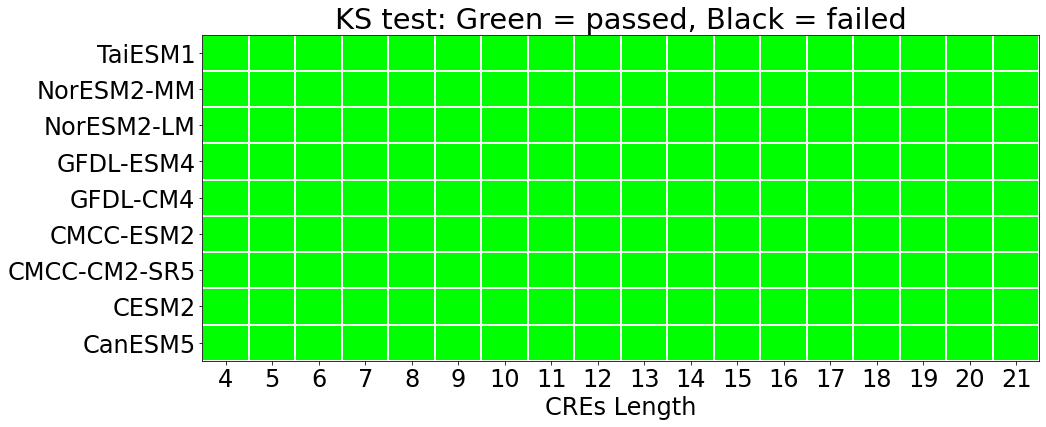

In [4]:
colors_binary = [(0, 0, 0), (0, 1, 0)]  # Black and Green
custom_cmap   = mcolors.LinearSegmentedColormap.from_list("custom_colormap", colors_binary, N=2)

array = np.zeros((len(model_names), len(Ls)))

for m, model_name in enumerate(model_names):
    for L_index, L in enumerate(Ls):
        
        pvalue = stats_dict[model_name][L]['P-value']

        if pvalue > 0.05:
            array[m, L_index] = 1
        else:
            print(f'P-value for {model_name} and length L = {L}: {pvalue:.3f} < 0.05 -> FAILED')


plt.figure(figsize=(15, 6))

plt.pcolormesh(Ls, list(model_names.keys()), array, cmap=custom_cmap, edgecolor="white", linewidth=0.1, vmin = 0, vmax = 1)
plt.title('KS test: Green = passed, Black = failed')
plt.xlabel("CREs Length")
plt.xticks(Ls)
plt.show()

---
## Graphical Interpretation of Results

We show CREs statistics for one climate model and different lengths L.

L = 7   - GEV fit: $\xi$ = -0.30, $\mu$ = 22.35 W/m$^2$, $\sigma$ = 3.96 W/m$^2$ (KS test: p-value = 0.27, D = 0.04 W/m$^2$)
L = 14   - GEV fit: $\xi$ = -0.29, $\mu$ = 28.14 W/m$^2$, $\sigma$ = 4.44 W/m$^2$ (KS test: p-value = 0.63, D = 0.03 W/m$^2$)
L = 21   - GEV fit: $\xi$ = -0.31, $\mu$ = 31.00 W/m$^2$, $\sigma$ = 4.28 W/m$^2$ (KS test: p-value = 0.75, D = 0.03 W/m$^2$)


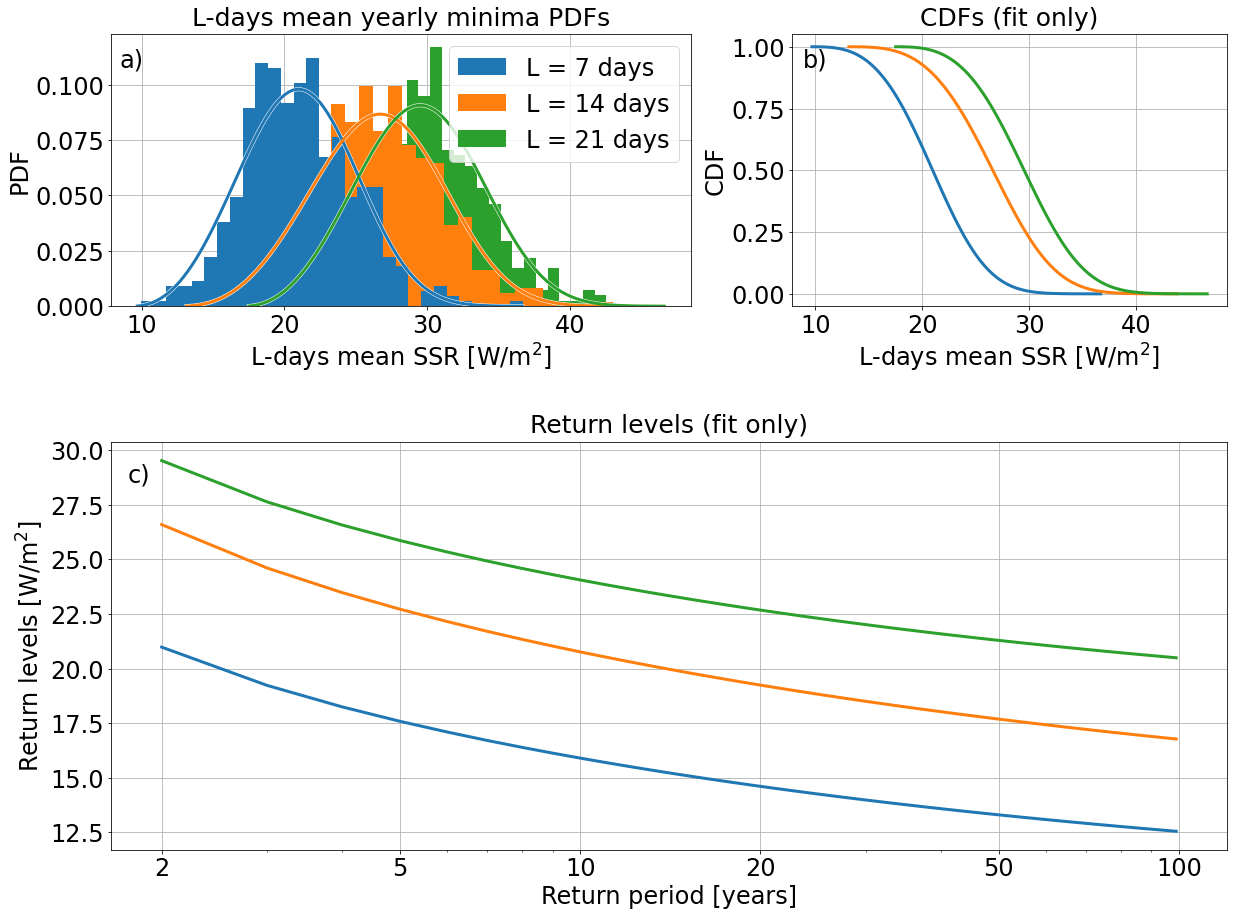

In [9]:
model_name = 'GFDL-ESM4' # Model of interest
Ls_to_plot = [7, 14, 21] # Choose 3 lengths of interest 

colors     = ['tab:blue', 'tab:orange', 'tab:green'] # Colors for the plot

flip_x     = -1 # Used to reswitch the sign of the data


fig = plt.figure(figsize = (20,15))
gs  = fig.add_gridspec(2, 2, height_ratios=[1, 1.5], width_ratios = [2, 1.5], hspace = 0.4)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])

for L_index, L in enumerate(Ls_to_plot):

    data, x_fit, pdf_fit, sorted_data, cdf, cdf_fit, c, mu, sigma, ks_statistic, p_value = stats_dict[model_name][L].values() # Load data from dictionnary
    
    print(f'L = {L}  ' + r' - GEV fit: $\xi$' + f' = {-c:.2f}, $\mu$ = {-mu:.2f} W/m$^2$, $\sigma$ = {sigma:.2f} W/m$^2$ (KS test: p-value = {p_value:.2f}, D = {ks_statistic:.2f} W/m$^2$)') # We print -c to show xi and -mu to reshift the sign of the data 

    ax = ax1 # Plot the PDFs

    ax.set_title('L-days mean yearly minima PDFs', fontsize = 25, y = 1.01)
    
    # Empirical histogram
    ax.hist(flip_x * data, bins=30, density=True, zorder= 4-L_index, label = f'{L = } days', color = colors[L_index]) 
    
    # Plot GEV pdf based on fit parameters
    ax.plot(flip_x * x_fit, pdf_fit, linewidth=3, zorder=5, color = colors[L_index])
    ax.plot(flip_x * x_fit, pdf_fit, linewidth=4, zorder=4, color = 'white')
    
    ax.set_xlabel(f'L-days mean SSR [W/m$^2$]')
    ax.set_ylabel("PDF")

    ax.legend()  

    ax = ax2 # Plot the CDFs
    ax.set_title('CDFs (fit only)', fontsize = 25, y = 1.01)

    # ax.scatter(flip_x * sorted_data, cdf, s=8) # Empirical CDF
    ax.plot(flip_x * x_fit, cdf_fit, lw = 3, color = colors[L_index]) # GEV CDF

    ax.set_xlabel(f'L-days mean SSR [W/m$^2$]')
    ax.set_ylabel("CDF")
    

    ax = ax3 # Plot the Return levels
    
    ax.set_title("Return levels (fit only)", fontsize = 25, y = 1.01)

    rp = np.arange(2.,100.,1.)                      # Return period in years
    pp = 1./rp                                      # Return probability
    z_p_fit = stats.genextreme.isf(pp, c, mu, sigma)   # GEV return period

    ax.plot(rp, flip_x * z_p_fit, lw = 3, color = colors[L_index]) # GEV return levels
    
    ax.set_xscale('log') # Logarithmic y-axis
    ticks = [2, 5, 10, 20, 50,  100]
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticks)
    ax.set_ylabel("Return levels [W/m$^2$]")
    ax.set_xlabel("Return period [years]")

    
for ax in [ax1, ax2, ax3]: ax.grid() 

ax1.legend()
ax1.text(0.015, 0.95, 'a)', transform=ax1.transAxes, va='top')
ax2.text(0.025, 0.95, 'b)', transform=ax2.transAxes, va='top')
ax3.text(0.015, 0.95, 'c)', transform=ax3.transAxes, va='top')

plt.savefig(f'Figures/CREs_Analysis/Fig_CREs_{model_name}.png', bbox_inches='tight')

plt.show()

We now show CREs statistics for all climate models considered for one specific event length.

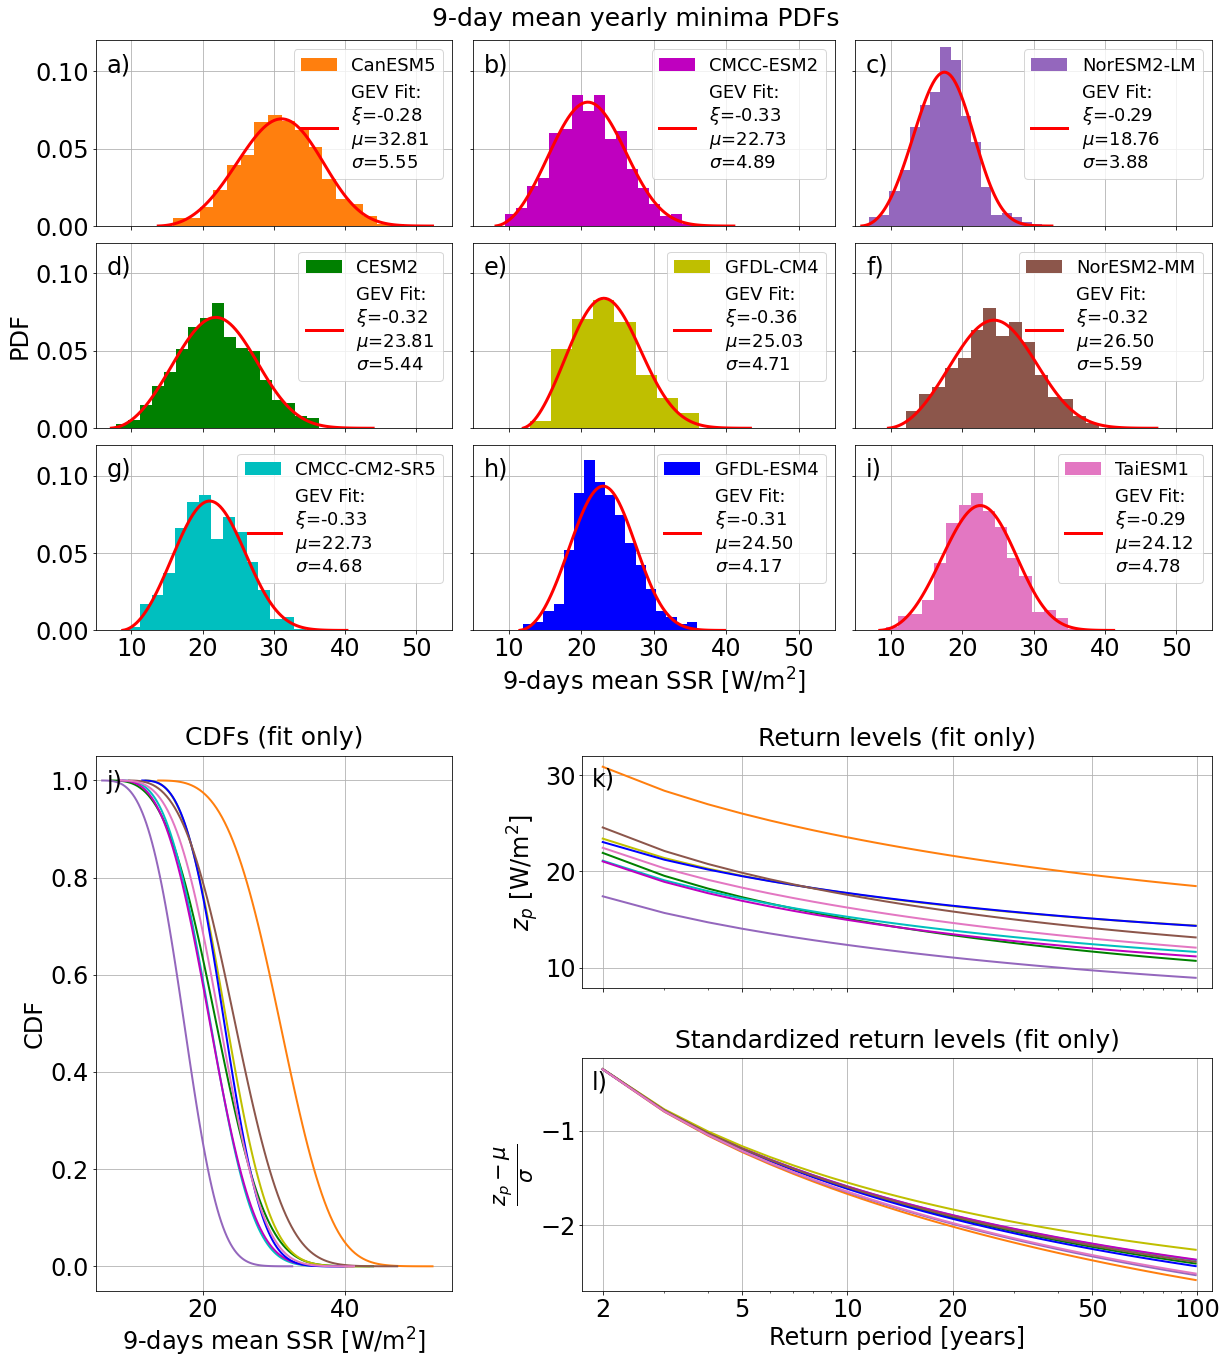

In [15]:
L        = 9                           # Choose the CRE length of interest for the plot

nbins    = 17*np.ones(13, dtype='int') # Set the number of bins for the histograms
nbins[4] = 8                           # Less bins for the GFDL-CM4 model as simulation length only 140 years

flip_x   = -1 # Used to reswitch the sign of the data

fig = plt.figure(figsize = (20,23))
gs  = fig.add_gridspec(7, 5, height_ratios=[1, 1, 1, 0.5, 1.25, 0.2, 1.25], width_ratios = [1, 0.25, 0.3, 0.35, 1], wspace = 0.1, hspace = 0.1) # Set plot geometry parameters

plt.suptitle(f'{L}-day mean yearly minima PDFs', fontsize = 25).set_y(0.9)

ax2 = fig.add_subplot(gs[4:,0:1]) # Plot for CDFs
ax3 = fig.add_subplot(gs[4,2:])   # Plot for return periods
ax4 = fig.add_subplot(gs[6,2:])   # Plot for standardised return periods

for m, model_name in enumerate(model_names):

    data, x_fit, pdf_fit, sorted_data, cdf, cdf_fit, c, mu, sigma, ks_statistic, p_value = stats_dict[model_name][L].values() # Load the data from the dictionnary

    n_years = time_series_dict[model_name]['n_years']
    color   = model_names[model_name]['color']

    if m < 3: # Plot for the PDFs
        ax = fig.add_subplot(gs[m,0])
    else:
        if m < 6:
            ax = fig.add_subplot(gs[m-3,1:4])
        else:
            ax = fig.add_subplot(gs[m-6,-1])

    ax.hist(flip_x * data, bins = nbins[m], density=True, color = color, label=model_name, zorder = 101) # Empirical histogram

    if stats_dict[model_name][L]['P-value'] > 0.05: # Plot PDF from GEV fit only if KS test is passed
        ax.plot(flip_x * x_fit, pdf_fit, label=f'GEV Fit: \n' +r'$\xi$' + f'={-c:.2f} \n$\mu$={-mu:.2f} \n$\sigma$={sigma:.2f}', color = 'red', linewidth = 3, zorder = 102) # GEV PDF

    # Set plot aesthetics and labels
    ax.legend(loc = 'upper right', fontsize = 18, facecolor='white').set_zorder(100)
    ax.grid(True, zorder=0)

    if m == 1: ax.set_ylabel("PDF")
    
    if m not in [0,1,2]:
       
        ax.set_ylabel('')
        ax.set_yticklabels('')

    ax.set_xticks([10, 20, 30, 40, 50])
    
    if m == 5:
        ax.set_xlabel(f'{L}-days mean SSR [W/m$^2$]')
    else:
        if m not in [2, 8]:
            ax.set_xticklabels('')
            ax.set_xlabel('')

    ax.set_xlim(5, 55)
    ax.set_ylim(0,0.12)

    # For the panel letters
    if m == 0: ax.text(0.03, 0.93, 'a)', transform=ax.transAxes, va='top')
    if m == 3: ax.text(0.03, 0.93, 'b)', transform=ax.transAxes, va='top')
    if m == 6: ax.text(0.03, 0.93, 'c)', transform=ax.transAxes, va='top')
    if m == 1: ax.text(0.03, 0.93, 'd)', transform=ax.transAxes, va='top')
    if m == 4: ax.text(0.03, 0.93, 'e)', transform=ax.transAxes, va='top')
    if m == 7: ax.text(0.03, 0.93, 'f)', transform=ax.transAxes, va='top')
    if m == 2: ax.text(0.03, 0.93, 'g)', transform=ax.transAxes, va='top')
    if m == 5: ax.text(0.03, 0.93, 'h)', transform=ax.transAxes, va='top')
    if m == 8: ax.text(0.03, 0.93, 'i)', transform=ax.transAxes, va='top')



    ax = ax2 # Plot the CDFs
    ax.set_title('CDFs (fit only)', fontsize = 25, y = 1.01)

    # ax.plot(-sorted_data, 1-cdf, color = colors[m], label = model_name, linewidth = 2) # Empirical CDF

    if stats_dict[model_name][L]['P-value'] > 0.05:
        ax.plot(flip_x * x_fit, cdf_fit, label='GEV Fit', color = color, linewidth = 2) # GEV CDF

    # Set plot aesthetics and labels
    ax.set_xlabel(f'{L}-days mean SSR [W/m$^2$]')
    ax.set_ylabel("CDF")
    ax.grid()
    ax.set_xlim(5, 55)


    ax = ax3 # Plot the return level
    ax.set_title("Return levels (fit only)", fontsize = 25, y = 1.02)

    
    rp = np.arange(1.,100.,1.)                      #return period in years
    pp = 1./rp                                      #return probability
    z_p_fit = stats.genextreme.isf(pp, c, mu, sigma)   #return levels from GEV fit parameters

    ax.plot(rp, flip_x * z_p_fit, label='GEV Fit', color = color, linewidth = 2) # GEV return levels
    
    # Set plot aesthetics and labels
    ax.set_xscale('log') 
    ticks = [2, 5, 10, 20, 50,  100]
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticks)
    ax.set_ylabel("$z_p$ [W/m$^2$]")
    ax.grid()
    ax.set_xticklabels('')
    ax.set_xlim(1.75,110)

    ax = ax4 # Plot the standardised return periods
    ax.set_title("Standardized return levels (fit only)", fontsize = 25, y = 1.02)

    ax.plot(rp, flip_x * (z_p_fit-mu)/sigma, label='GEV Fit', color = color, linewidth = 2) # Same as ax3 but with standardised return levels z_p -> (z_p-mu)/sigma
    
    # Set plot aesthetics and labels
    ax.set_xscale('log') 
    ticks = [2, 5, 10, 20, 50,  100]
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticks)
    ax.set_ylabel(r"$\frac{z_p - \mu}{\sigma}$", fontsize=30)
    ax.set_xlabel("Return period [years]")
    ax.grid()
    ax.set_xlim(1.75,110)
    

ax2.text(0.03, 0.975, 'j)', transform=ax2.transAxes, va='top')
ax3.text(0.015, 0.95, 'k)', transform=ax3.transAxes, va='top')
ax4.text(0.015, 0.95, 'l)', transform=ax4.transAxes, va='top')


plt.savefig(f'Figures/CREs_Analysis/Fig_CREs_Analysis.png', bbox_inches='tight')

plt.show()

We show the GEV fit parameters for all models and all lengths considered.

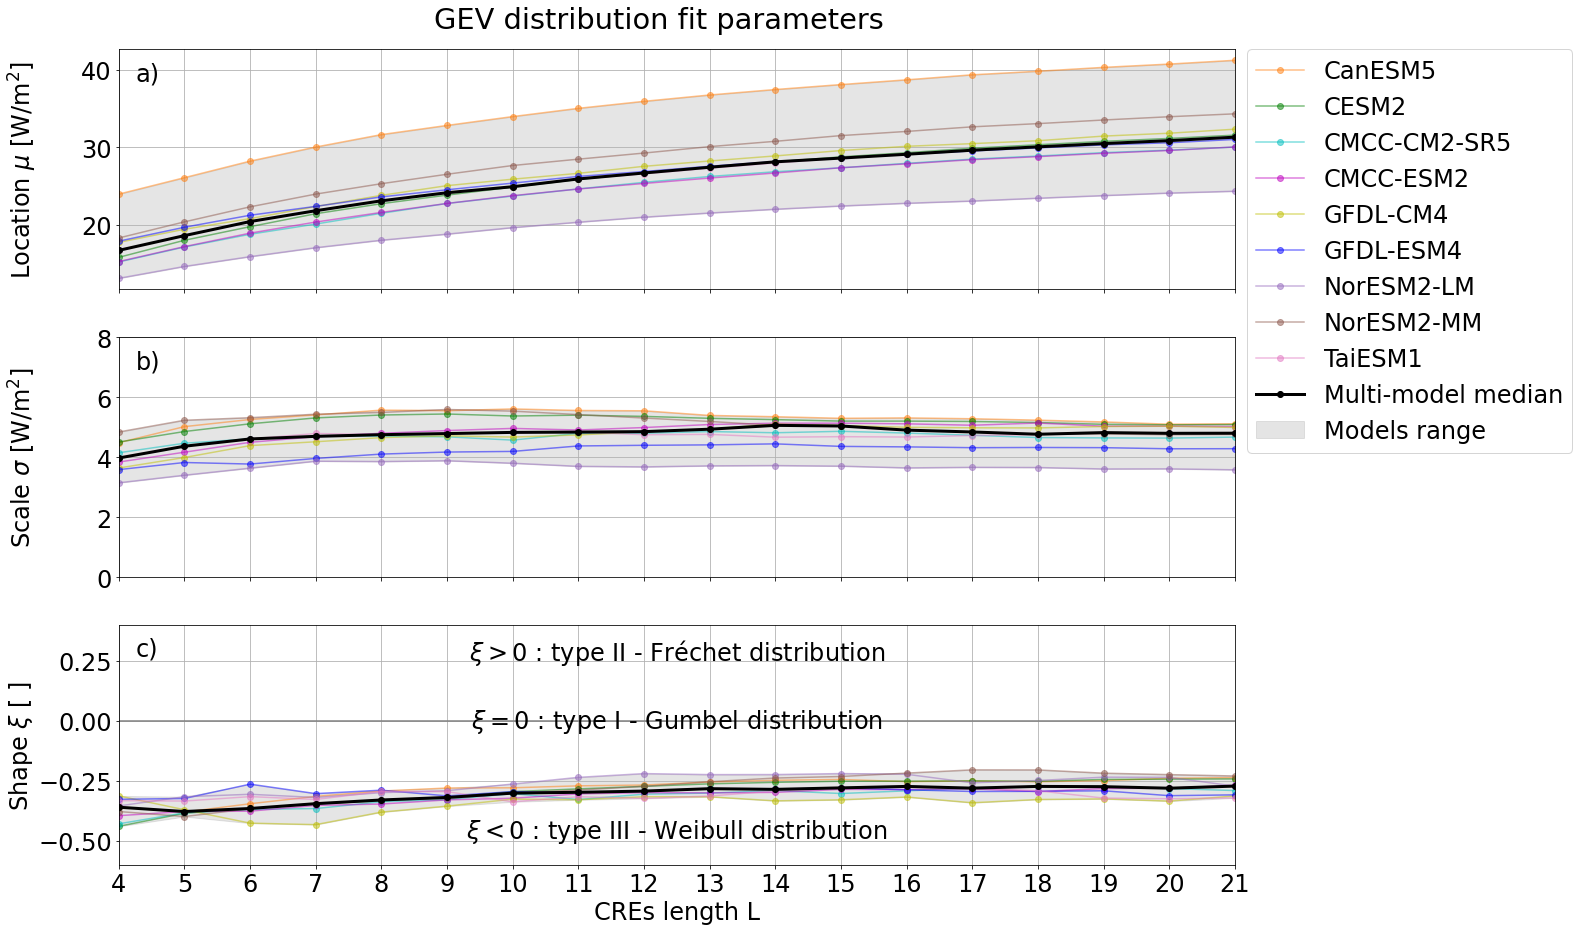

In [16]:
parameters = ['Location', 'Scale', 'Shape']

ylabels    = ['Location $\mu$ [W/m$^2$]', 'Scale $\sigma$ [W/m$^2$]', r'Shape $\xi$ [ ]']


all_params = np.empty((len(model_names), len(parameters), len(Ls))) # Empty array to compute median later

fig = plt.figure(figsize = (20,15))
gs  = fig.add_gridspec(3, 1)

plt.suptitle('GEV distribution fit parameters').set_y(0.92)

ax1 = fig.add_subplot(gs[0, 0]) # Plot for parameters[0] 
ax2 = fig.add_subplot(gs[1, 0]) # Plot for parameters[1] 
ax3 = fig.add_subplot(gs[2, 0]) # Plot for parameters[2] 


axs = [ax1, ax2, ax3]

for m, model_name in enumerate(model_names):

    color = model_names[model_name]['color']

    for p_index, parameter in enumerate(parameters):

        ax  = axs[p_index]
    
        if parameter == 'Scale': # Get the parameter value for all length of the model_name
            all = [values[parameter] for values in stats_dict[model_name].values()] # Take the value if parameter is sigma
        else:
            all = [-values[parameter] for values in stats_dict[model_name].values()] # Take minus the value if parameter is mu or c

        all_params[m, p_index, :] = all # To compute the median leter

        ax.plot(Ls, all, marker = 'o', alpha = 0.5, color = color, label = model_name) # Plot all parameter values for model_name

        # Set plot aesthetics and labels
        ax.set_xticks(Ls)
        if p_index !=2:
            ax.set_xticklabels('')

        if m == 0:
            ax.text(-0.1, 0.5, ylabels[p_index], transform=ax.transAxes, va = 'center', rotation = 'vertical')


# Plot the multi-model median for each parameter
for p_index, parameter in enumerate(parameters):

    ax = axs[p_index]

    ax.plot(Ls, np.median(all_params[:,p_index,:], axis = 0), color = 'black', marker = 'o', linewidth = 3, label = 'Multi-model median')

    ax.fill_between(x=Ls, y1=np.min(all_params[:,p_index,:], axis = 0), y2=np.max(all_params[:,p_index,:], axis = 0), color =  'gray', label = 'Models range', alpha = .2) # show the model range with grey shading

    ax.set_xlim(np.min(Ls), np.max(Ls))


# Set plot aesthetics and labels
for ax in axs: ax.grid()

ax1.legend(bbox_to_anchor=(1, 1.05))
ax2.set_ylim(0,8)
ax3.plot([0, 21], [0, 0], color = 'gray')
ax3.set_ylim(-.6, 0.4)


ax3.set_xlabel(f'CREs length L')

ax3.text(0.5, 0.95, r'$\xi>0$ : type II - Fréchet distribution', transform=ax3.transAxes, ha='center', va = 'top')
ax3.text(0.5, 0.66, r'$\xi=0$ : type I - Gumbel distribution', transform=ax3.transAxes, ha='center', va = 'top')
ax3.text(0.5, 0.2, r'$\xi<0$ : type III - Weibull distribution', transform=ax3.transAxes, ha='center', va = 'top')

ax1.text(0.015, 0.95, 'a)', transform=ax1.transAxes, va='top')
ax2.text(0.015, 0.95, 'b)', transform=ax2.transAxes, va='top')
ax3.text(0.015, 0.95, 'c)', transform=ax3.transAxes, va='top')

plt.savefig(f'Figures/CREs_Analysis/Fig_CREs_Parameters.png', bbox_inches='tight')

plt.show()

We compare SciPy output with GEV theory for one example model and length L to help us understand how to use the SciPy functions. 

For the theoretical standardized GEV expressions ($\xi \neq 0$, $z = \frac{x-\mu}{\sigma}$) (see https://en.wikipedia.org/wiki/Generalized_extreme_value_distribution):

- Probability Density Function (PDF): $$ \mathrm{PDF}(z;\xi) = \exp\left[-(1+\xi z)^{-1/\xi}\right] \times (1+\xi z)^{-1/\xi - 1}$$

- Cumulative Distribution Function (CDF): $$ \mathrm{CDF}(z;\xi) = \exp\left[-(1+\xi z)^{-1/\xi}\right] $$

- Return levels ($z_p$) (see Huang et al. (2016) doi:10.5194/ascmo-2-79-2016)): $$ z_p(p;\xi) = \frac{1}{\xi} \left[1-\{-\ln(1-p)\}^{-\xi}\right] $$

L = 9   - GEV fit: $\xi$ = -0.28, $\mu$ = 32.81 W/m$^2$, $\sigma$ = 5.55 W/m$^2$ (KS test: p-value = 0.96, D = 0.02 W/m$^2$)


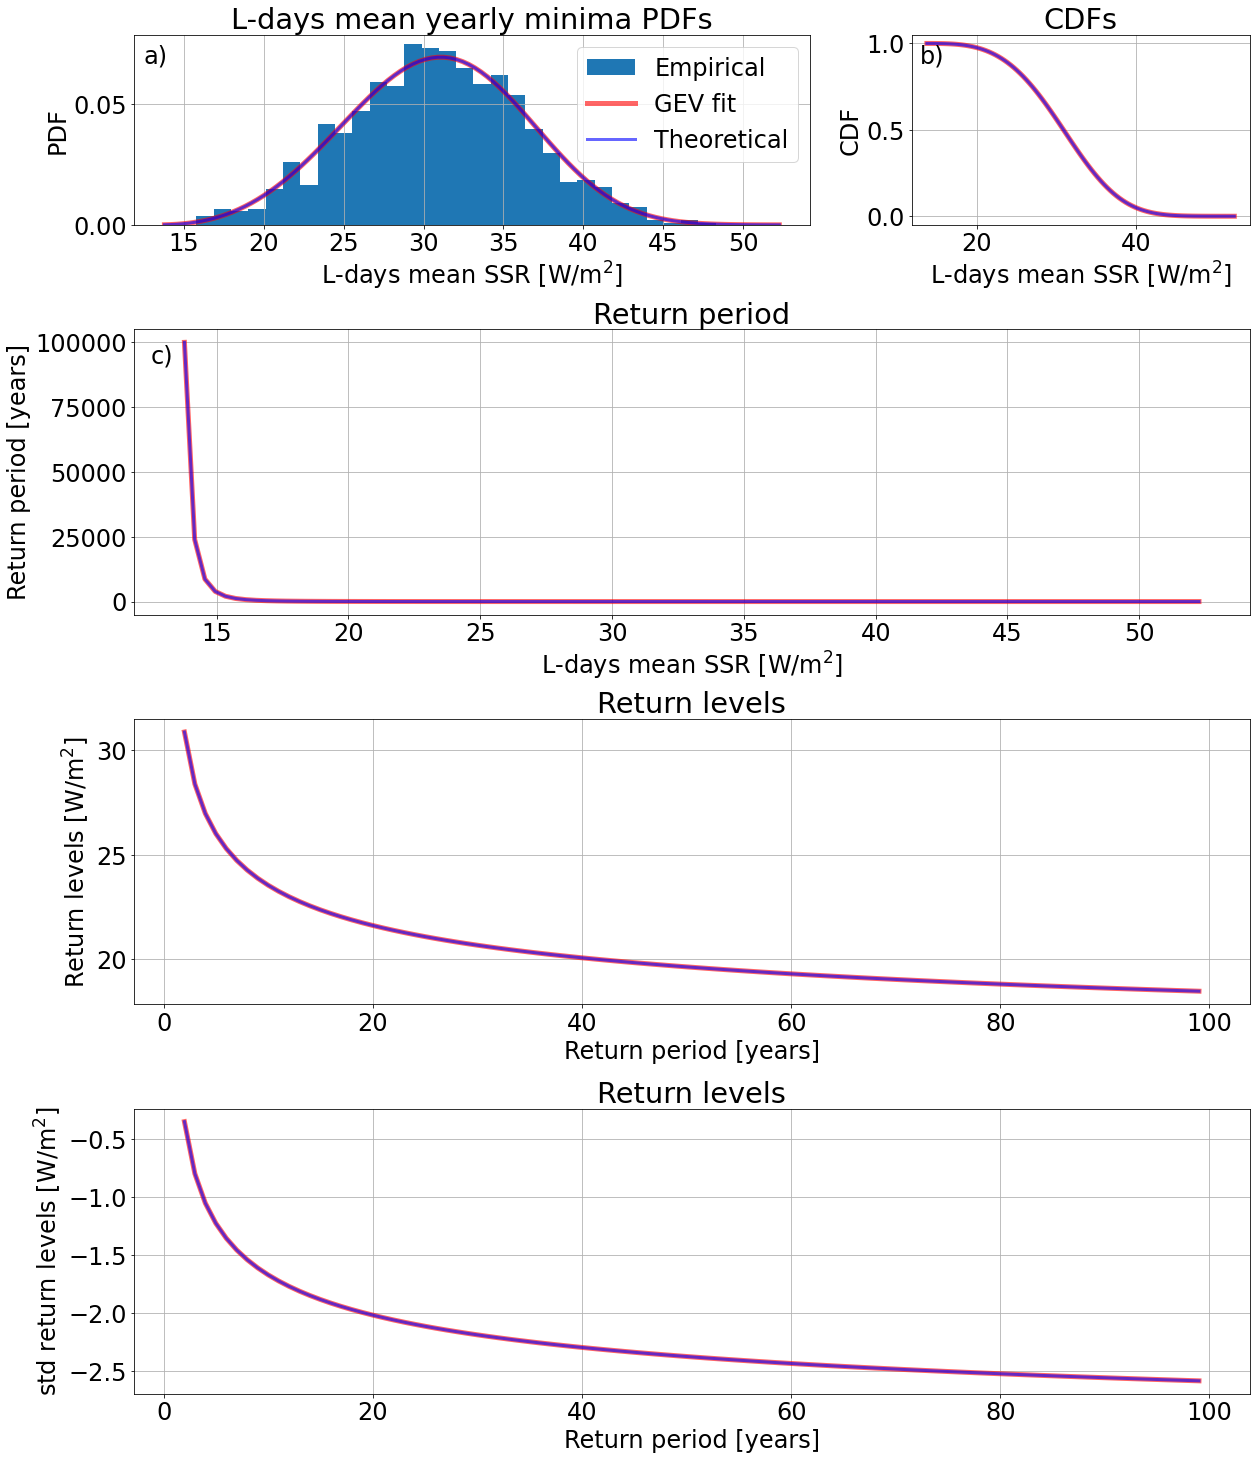

In [21]:
model_name = 'CanESM5' # Model of interest for the example
Ls_to_plot = [9]       # Length of interest for the example

flip_x = -1 # Used to reswitch the sign of the data

fig = plt.figure(figsize = (20,25))
gs  = fig.add_gridspec(4, 2, height_ratios=[1, 1.5, 1.5, 1.5], width_ratios = [2, 1], hspace = 0.4)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])
ax4 = fig.add_subplot(gs[2, :])
ax5 = fig.add_subplot(gs[3, :])


for L_index, L in enumerate(Ls_to_plot): # In case we want to look at more than one length (all the curves will have the same color)

    data, x_fit, pdf_fit, sorted_data, cdf, cdf_fit, c, mu, sigma, ks_statistic, p_value = stats_dict[model_name][L].values()
    
    print(f'L = {L}  ' + r' - GEV fit: $\xi$' + f' = {-c:.2f}, $\mu$ = {-mu:.2f} W/m$^2$, $\sigma$ = {sigma:.2f} W/m$^2$ (KS test: p-value = {p_value:.2f}, D = {ks_statistic:.2f} W/m$^2$)')

    ax = ax1 # Plot the PDFs
    ax.set_title('L-days mean yearly minima PDFs')  

    xi = -c 
    z = (x_fit-mu)/sigma
    t = np.power(1+xi*z,-1./xi) 
    q = np.power(t,xi+1)/sigma 
    pdf_theory = np.exp( -t ) * q # Theoretical PDFs    

    
    ax.hist(flip_x * data, bins=30, density=True, lw = 3, label = 'Empirical')            # Empirical
    ax.plot(flip_x * x_fit, pdf_fit, 'r-', lw=5, alpha=0.6, label = 'GEV fit')            # GEV
    ax.plot(flip_x * x_fit, pdf_theory, 'b-', lw = 3, alpha = 0.6, label = 'Theoretical') # Theorical
    
    ax.set_xlabel(f'L-days mean SSR [W/m$^2$]')
    ax.set_ylabel("PDF")
    
    ax = ax2 # Plot the CDFs
    ax.set_title('CDFs')


    cdf_theory = np.exp( -t )  

    
    # ax.scatter(flip_x * sorted_data, cdf, s=8)                     # Empirical
    ax.plot(flip_x * x_fit, cdf_fit, 'r-', lw=5, alpha=0.6)        # GEV
    ax.plot(flip_x * x_fit, cdf_theory, 'b-', lw = 3, alpha = 0.6) # Theorical

    ax.set_xlabel(f'L-days mean SSR [W/m$^2$]')
    ax.set_ylabel("CDF")
    

    ax = ax3 # Plot the Return period
    ax.set_title("Return period")


    
    # ax.plot(sorted_data, 1./(1.-cdf), color = 'green')                # Empirical
    ax.plot(flip_x * x_fit, 1./(1.-cdf_fit),'r-', lw=5, alpha=0.6)    # GEV
    ax.plot(flip_x * x_fit, 1./(1.-cdf_theory),'b-', lw=3, alpha=0.6) # Theoretical

    ax.set_ylabel("Return period [years]")
    ax.set_xlabel(f'L-days mean SSR [W/m$^2$]')


    ax = ax4 # Plot the Return levels
    ax.set_title("Return levels")

    # Compute return levels using SciPy
    rp = np.arange(2.,100.,1.)  #return period in years
    pp = 1./rp                  #return probability
    z_p_fit = stats.genextreme.isf(pp, c, mu, sigma) #return levels from SciPy

    ax.plot(rp, flip_x * z_p_fit,'r-', lw=5, alpha=0.6, label='return period scipy')        # GEV
    
    # Compute theoretical return levels
    tt = -1.0*np.log(1.-pp)
    z_p_theory = mu - sigma/xi*(1.0 - np.power(tt, -xi)) # theoretical return level formula 
    
    ax.plot(rp, flip_x * z_p_theory,'b-', lw=3, alpha=0.6, label='return period analytical') # Theoretical 

    ax.set_ylabel("Return levels [W/m$^2$]")
    ax.set_xlabel("Return period [years]")

    ax = ax5 # Plot the std Return levels
    ax.set_title("Return levels")

    rp = np.arange(2.,100.,1.)  #return period in years
    pp = 1./rp                  #return probability
    z_p_fit = stats.genextreme.isf(pp, c, mu, sigma) #return levels from SciPy

    ax.plot(rp, flip_x * (z_p_fit-mu)/sigma,'r-', lw=5, alpha=0.6, label='return period scipy')         # GEV
    ax.plot(rp, flip_x * (z_p_theory-mu)/sigma,'b-', lw=3, alpha=0.6, label='return period analytical') # Theoretical

    ax.set_ylabel("std return levels [W/m$^2$]")
    ax.set_xlabel("Return period [years]")

    
for ax in [ax1, ax2, ax3, ax4, ax5]: ax.grid() 

ax1.legend()
ax1.text(0.015, 0.95, 'a)', transform=ax1.transAxes, va='top')
ax2.text(0.025, 0.95, 'b)', transform=ax2.transAxes, va='top')
ax3.text(0.015, 0.95, 'c)', transform=ax3.transAxes, va='top')

plt.savefig(f'Figures/CREs_Analysis/CREs_{model_name}.png', bbox_inches='tight')

plt.show()